In [2]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from scipy.linalg import expm
from distanceclosure.dijkstra import all_pairs_dijkstra_path_length
import scipy.stats as sp
import scipy
from distanceclosure.closure import distance_closure


### Generic functions

In [3]:
def compute_size_network(network): ### Returns the number of nodes in the network, network is a dataframe where there should be at least two columns with the source and target of each edge
    return len(list(set(list(network['source'].unique())+list(network['target'].unique()))))

def node_list(network): ### Returns the list of nodes in the network, network is a dataframe where there should be at least two columns with the source and target of each edge
    return list(set(list(network['source'].unique())+list(network['target'].unique())))


def get_neighborhood_properties(network): ### This fucntion produces a dictionary with all the neighbors of a node and the corresponding weights of their interactions 
    nodes=node_list(network)
    out_neighbors={i:[] for i in nodes}
    out_weights={i:[] for i in nodes}
    for index, row in network.iterrows():
        if(row['proximity']!=0):
            out_neighbors[row['source']].append(row['target'])
            out_weights[row['source']].append(row['proximity'])
            out_neighbors[row['target']].append(row['source'])
            out_weights[row['target']].append(row['proximity'])
    return out_neighbors,out_weights

def sort_edges(df): ### Sort edges according to their source and target
    sources=[]
    target=[]
    for index,row in df.iterrows():
        if (row['source']>row['target']):
            sources.append(row['target'])
            target.append(row['source'])
        else:
            sources.append(row['source'])
            target.append(row['target'])
    df['source']=sources
    df['target']=target
    return df

def directed_network_to_undirected(G): ## Symmetrize a weighted network by considering the sum of weights
    
    UG = G.to_undirected()
    for node in G:
        for ngbr in nx.neighbors(G, node):
            if node in nx.neighbors(G, ngbr):
                UG.edges[node, ngbr]['proximity'] = (
                    G.edges[node, ngbr]['proximity'] + G.edges[ngbr, node]['proximity']
            )
    UG.edges.data('proximity')
    return UG
    

### Function to create the synthetic network with tunable semi-metric topology

In [4]:
def create_synthetic_network(G_metric,G_closure,tau,mu,sigma): ### Create a synthetic network with tunable size of the metric backbone and features of the semi-metric distortion distribution  
    ### G_metric is a networkx object containing the metric backbone of a network. As such, it should be connected and all the edges should constitute the shortest path between their ends
    #### G_closure is a networkx object representing the distance closure matrix in the metric space of the network, i.e. the length of the shortest path connecting every single pair of nodes in the network. 
    newG=G_metric.copy() ## Copy the metric backbone that will constitute the substrate on which build the rest of the network
    G_closure.remove_edges_from(G_metric.edges())
    G_closure_semi_metric=G_closure.copy() ### Only the shortest path distance of the semi-metric edges not included in the metric backbone
    E = int((1./tau - 1.)*G_metric.number_of_edges()) ### Set the number of edges which should be added to the network
    semi_edges=list(G_closure_semi_metric.edges()) ### List of the semi-metric edges
    np.random.shuffle(semi_edges) ## Randomize the set of semi-metric edges
    semi_edges=semi_edges[:E] ### Select E semi-metric edges
    s_values = np.random.lognormal(mean=mu, sigma=sigma, size=len(semi_edges)) ### Drawn the semi-distortion values from a log-normal distribution with parametrs mu and sigma 
    s_values=s_values+1 #### Add one as the former function generates values between 0 and infinity and, by definition, semi-metric distortion of semi-metric edges should be above 1
    for idx, (u,v) in enumerate(semi_edges): ##Add the edges
        d = s_values[idx]*G_closure_semi_metric[u][v]['metric_distance'] ## Set distance according to the semi-metric distortion and the length of the shortest path (included in the closure)
        p = 1./(d+1.)   ### Set the proximity value through the isomorphism
        newG.add_edge(u,v,**{'distance':d, 'proximity':p,'s_value':s_values[idx],'metric':False,'metric_distance':G_closure_semi_metric[u][v]['metric_distance']}) ## Add edges
    return newG ## return another networkx object with the new synthetic network

### Function to extract the backbone and the semi-metric topology of a given network

In [5]:
def compute_backbone(name,df): ### Function to compute the backbone of a given network introduced as pandas DataFrame
    ### the network dataframe should have two columns, 'source' and 'target' to encode the endpoints of each edge

    # Only keep edges originally in the graph
    df = df.loc[df['original'] == True, :]

    # To NetworkX
    edge_attr = [
        #'b_ij_value',
        #'b_ji_value',
        #'count',
        'distance',
        #'distance_metric_closure',
        #'distance_ultrametric_closure',
        #'metric',
        'original',
        #'proximity',
        #'s_value',
        #'ultrametric',
        'proximity',
        ]
    G = nx.from_pandas_edgelist(df, source='source', target='target', edge_attr=edge_attr) ### pass the network to networkx format keeping some of the attributes (distance and proximity are the most relevant)

    # Remove self-loops (just in case)
    print('Remove self-loops')
    G.remove_edges_from(list(nx.selfloop_edges(G)))

    print('--- Computing Dijkstra APSP ---')
    #
    # Metric computation
    #
    c = 1
    for i, metric_distances in all_pairs_dijkstra_path_length(G, weight='distance', disjunction=sum):
        if c % 10 == 0:
            print('> Metric Dijkstra: {c:} of {total:}'.format(c=c, total=G.number_of_nodes()))
        for j, metric_distance in metric_distances.items():

            # New Edge?
            if not G.has_edge(i, j):
                # Self-loops have proximity 1, non-existent have 0
                """
                proximity = 1.0 if i == j else 0.0
                G.add_edge(i, j, distance=np.inf, proximity=proximity, metric_distance=float(cm), is_metric=False)
                """
            else:
                G[i][j]['metric_distance'] = metric_distance ## metric distance measures the shortest path distance between the two nodes
                G[i][j]['metric'] = True if ((metric_distance == G[i][j]['distance']) and (metric_distance != np.inf)) else False ## True if the edge belongs to the metric backbone
        c += 1

    print('--- Calculating S Values ---')

    S_dict = {
        (i, j): float(d['distance'] / d['metric_distance']) ### compute distortion value of the edge
        for i, j, d in G.edges(data=True)
        if ((d.get('distance') < np.inf) and (d.get('metric_distance') > 0))
    }
    nx.set_edge_attributes(G, name='s_value', values=S_dict)

   # print('--- Exporting Formats ---')
    #utils.ensurePathExists(wGgraphml)
    #utils.ensurePathExists(wGpickle)
    #utils.ensurePathExists(wGcsv)
    dfG = nx.to_pandas_edgelist(G)
    return dfG ### return dataframe with the network and additional information regarding whether edges are metric or not and their associated semi-metric distortionreturn UG

### Functions to simulate SI dynamics

In [6]:
def initiate_configuration(seed,nodes): ### Set the infectious seed for the SI dynamics
    states={i:0 for i in nodes}
    states[seed]=1
    return states


def update_inf_probabilities(beta,dt,out_neighbors,out_weights,probability_of_infection,new_nodes_infected): ## This function updates the probability of infection of the neighboring nodes of those contracting the disease at a given time step
    ## beta is the contagion rate
    ### dt is the length of the discrete time step considered in the simulaitons
    ### out_weights contains the set of weights connecting one individual with its neighbors
    ### probability of infection measures the probability that a node gets the disease according to the dynamical state of the set of neighbors
    ### new_nodes_infected is a list containing those contracting the disease at a given time step
    for i in new_nodes_infected:
        for j in range(len(out_neighbors[i])):
            probability_of_infection[out_neighbors[i][j]]=1.0-(1.0-probability_of_infection[out_neighbors[i][j]])*(1.0-beta*dt*out_weights[i][j])

    return probability_of_infection
    
def simulateSI(seed,beta,dt,network): ### Simulate the SI dynamics considering a single seed of infection in a given network (DataFrame format)
    #Initiate the dynamics
    nodes=node_list(network) #Compute list of nodes in the network
    size=len(nodes) ## Compute the number of nodes in the network
    states=initiate_configuration(seed,nodes) #Initial configuration of the individuals
    out_neighbors,out_weights=get_neighborhood_properties(network) #Get list of neighbors and weights
    time_of_infection={i:0 for i in nodes}#Dictionary to track the time of infection of each node
    probability_of_infection={i:0 for i in nodes}#Set the probability of infection for each node
    susceptible_nodes=nodes.copy()
    susceptible_nodes.remove(seed) #Identify the susceptible nodes
    #Get the probability of infection of those nodes in contact with the infectious seed
    probability_of_infection=update_inf_probabilities(beta,dt,out_neighbors,out_weights,probability_of_infection,[seed])
    for key,items in probability_of_infection.items():
        if np.isnan(items)==True:
            print('ERROR')
    ninf=1 ### Count the number of infected individuals
    step=0 ## Set the current time step
    while(ninf!=size): ### Iterate SI dynamics until all the nodes get infected
        step+=1  ## Advance one time step
        new_contagions=[i for i in susceptible_nodes if random.random()<probability_of_infection[i]] ### List with the new contagions at this time step
        new_contagions=list(set(new_contagions)) ### A node can get infected multiple times in a time step if it's neighbor of multiple infected individuals. For this reason, we must remove duplicates
        for i in new_contagions:
            time_of_infection[i]=step*dt ## Set the time of infection of nodes getting the disease at the current time step 
            susceptible_nodes.remove(i) ## remove them from the list of susceptible nodes
            ninf+=1 ### updates the number of infected individuals in the population
        probability_of_infection=update_inf_probabilities(beta,dt,out_neighbors,out_weights,probability_of_infection,new_contagions) ### update the probability of infection of the remaining nodes
    return time_of_infection ### return the dictionary with the times of infection of each node

### Create a synthetic network with tunable metric backbone and semi-metric distortion distribution from a weighted network

First thing, we'll do is to apply the Jaccard normalization to weights and to extract the metric backbone and the distortion values 

In [7]:
city='Albany'
#### Read mobility data
mobilitynetwork=pd.read_csv('../Data/mobility_network_%s.csv'%city)
G = nx.from_pandas_edgelist(mobilitynetwork, source='source', target='target', edge_attr=['proximity'],create_using=nx.DiGraph()) ## convert to a networkx object
G =directed_network_to_undirected(G) ### Turn the directed network into an undirected one to make the metric backbone algorithm work (Here we only consider undirected networks)
G = G.subgraph(max(nx.connected_components(G), key=len)) ## Get the largest connected component
mobilitydef = nx.to_pandas_edgelist(G) ### dataframe with the clean network

####Compute Jaccard normalization
strength_source=mobilitydef.groupby('source')['proximity'].sum().reset_index()
strength_source.columns=['node','strength_source'] ### Compute strength of all the connection where one node is the source

strength_target=mobilitydef.groupby('target')['proximity'].sum().reset_index()
strength_target.columns=['node','strength_target'] ### Compute strength of all the connection where one node is the target

strength_total=pd.merge(strength_source,strength_target,on='node',how='outer') ### Get a dataframe with both strengths
strength_total=strength_total.fillna(0) ## In case one node is not a target or a source of any connections

strength_total['strength']=strength_total['strength_source']+strength_total['strength_target'] ### Get the strength of the node

strength_total=strength_total[['node','strength']] 
strength_total.columns=['source','strength_source'] 

mobilitydef=pd.merge(mobilitydef,strength_total,on='source')
strength_total.columns=['target','strength_target']

mobilitydef=pd.merge(mobilitydef,strength_total,on='target') ###get dataframe indicating the weight of the edge and the strength of the endpoints

mobilitydef['proximity']=mobilitydef['proximity']/(mobilitydef['strength_source']+mobilitydef['strength_target']-mobilitydef['proximity']) ### Apply Jaccard normalization to the weights

mobilitydef['distance']=1.0/mobilitydef['proximity']-1 ## Apply isomorphism to get the associated distance to each edge
mobilitydef['original']=True ## flag that indicates that the edge belongs to the original network
network=compute_backbone(city,mobilitydef) ## Compute metric backbone and semimetric distortion, obtaining the network dataframe with information on the semi-metric topology
network.to_csv('../Data/network_with_semi_metric_topology_%s.csv'%city,index=False)

Remove self-loops
--- Computing Dijkstra APSP ---
> Metric Dijkstra: 10 of 127
> Metric Dijkstra: 20 of 127
> Metric Dijkstra: 30 of 127
> Metric Dijkstra: 40 of 127
> Metric Dijkstra: 50 of 127
> Metric Dijkstra: 60 of 127
> Metric Dijkstra: 70 of 127
> Metric Dijkstra: 80 of 127
> Metric Dijkstra: 90 of 127
> Metric Dijkstra: 100 of 127
> Metric Dijkstra: 110 of 127
> Metric Dijkstra: 120 of 127
--- Calculating S Values ---


In [8]:
network

,source,target,original,distance,metric_distance,proximity,s_value,metric
0,12007,12054,True,6218.0,353.146735,0.000161,17.607412,False
1,12007,12203,True,17728.0,403.032811,0.000056,43.986493,False
2,12007,12206,True,10657.0,414.677262,0.000094,25.699504,False
3,12007,12305,True,9671.0,474.226042,0.000103,20.393228,False
4,12007,12208,True,19158.0,384.058423,0.000052,49.883036,False
...,...,...,...,...,...,...,...,...
4617,12022,12040,True,162.5,158.645833,0.006116,1.024294,False
4618,12064,12076,True,208.0,135.360000,0.004785,1.536643,False
4619,12076,12131,True,176.0,88.693333,0.005650,1.984366,False
4620,12076,12194,True,99.0,44.693333,0.010000,2.215095,False


In [9]:
metric_network=network[network['metric']==True] ### get the metric backbone

In [10]:
G_metric=nx.from_pandas_edgelist(metric_network,source='source',target='target',edge_attr=['distance','proximity','metric_distance','s_value','metric']) ## generate networkx object from the pandas dataframe of the metric backbone
G_closure=distance_closure(G_metric, kind='metric', weight='distance', only_backbone=False) ### Get the distance closure of the network

Once we have both the metric backbone and the closure matrix, we can generate and save the synthetic network

In [11]:
tau=0.10 ## Relative size of the backbone
mu=1 ## Mean value of the lognormal distribution
sigma=1 ## Standard deviation
G_synthetic=create_synthetic_network(G_metric,G_closure,tau,mu,sigma) ## Networkx object with the synthetic network created
df_synthetic=nx.to_pandas_edgelist(G_synthetic) ## dataframe with the synthetic network


### Implement SDS and perform SI dynamics

In [12]:
network_name='Albany'
network_original=pd.read_csv('../Data/network_with_semi_metric_topology_%s.csv'%network_name)
metric_network=network_original[network_original['metric']==True]
realizations=30 ### Number of outbreaks simulated for each infectious seed
beta=0.5 ### Infectiousness parameter
dt=0.1 ### Duration of each time step
nodes=node_list(network_original) #Compute nodes of the network
results=[]
seeds=random.choices(nodes,k=10) ### Set k different locations for the seeds. IMPORTANT: When comparing with other methods/sizes of the network, keep the same set of nodes as seeds for a fair comparison
semi_metric_network=network_original[network_original['metric']==False].sort_values('s_value',ascending=True) ### All semi-metric edges sorted from the lowest to the highest distorsion values
chi_values = np.arange(0,1.01,0.05) ## chi controls the size of the sparsified network. Fraction of semi-metric edges remaining in the network after sparsifying. chi=1 original network, chi=0 metric backbone

for chi in chi_values: 
    sample_size=int(chi*len(semi_metric_network)) ### Number of semi-metric edges included 
    network_used=metric_network.append(semi_metric_network.head(sample_size)) ## Keep those semi-metric edges with lowest distorsion values
    for seed in seeds:
        for real in range(realizations):
            time_distribution=list(simulateSI(seed,beta,dt,network_used).values()) ## get a dictionary with the times of infection of all nodes
            results.append(tuple([beta,chi,network_name,seed,real,[np.quantile(time_distribution,x).round(1) for x in np.arange(0.1,1.01,0.1)]])) ### append for each realization and seed
            real+=1
        print('Chi %.2f, Seed %d is done'%(chi,seed))
            
df_results=pd.DataFrame(results,columns=['beta','size','network','seed','realization','times']) # Create a dataframe with the parameters and the result (last column). Last column corresponds to a list of times at which a given quantile of nodes (10%,20%,30%...) gets infected.

Chi 0.00, Seed 12196 is done
Chi 0.00, Seed 12046 is done
Chi 0.00, Seed 12831 is done
Chi 0.00, Seed 12041 is done
Chi 0.00, Seed 12025 is done
Chi 0.00, Seed 12158 is done
Chi 0.00, Seed 12122 is done
Chi 0.00, Seed 12120 is done
Chi 0.00, Seed 12167 is done
Chi 0.00, Seed 12008 is done
Chi 0.05, Seed 12196 is done
Chi 0.05, Seed 12046 is done
Chi 0.05, Seed 12831 is done
Chi 0.05, Seed 12041 is done
Chi 0.05, Seed 12025 is done
Chi 0.05, Seed 12158 is done
Chi 0.05, Seed 12122 is done
Chi 0.05, Seed 12120 is done
Chi 0.05, Seed 12167 is done
Chi 0.05, Seed 12008 is done
Chi 0.10, Seed 12196 is done
Chi 0.10, Seed 12046 is done
Chi 0.10, Seed 12831 is done
Chi 0.10, Seed 12041 is done
Chi 0.10, Seed 12025 is done
Chi 0.10, Seed 12158 is done
Chi 0.10, Seed 12122 is done
Chi 0.10, Seed 12120 is done
Chi 0.10, Seed 12167 is done
Chi 0.10, Seed 12008 is done
Chi 0.15, Seed 12196 is done
Chi 0.15, Seed 12046 is done
Chi 0.15, Seed 12831 is done
Chi 0.15, Seed 12041 is done
Chi 0.15, Seed

### Plot results of SDS

In [13]:
chi_values=np.arange(0.0,1.01,0.05)
network_names=['Albany']
results_ratio=pd.DataFrame()
for network in network_names:
    results=pd.DataFrame()
    for chi in chi_values:
        results_partial=df_results[df_results['size']==chi]
        results_partial['t_half']=[results_partial['times'].values[i][4] for i in range(len(results_partial))]## if obtaining results as a variable within the notebook
        #results_partial['t_half']=[results_partial['times'].values[i].split(',')[4] for i in range(len(results_partial))] ### if reading the results from a file
        results_partial['t_half']=results_partial['t_half'].astype(float)
        results_partial['seed']=results_partial['seed'].astype(int)
        #results_partial=results_partial.groupby(['seed','size','network','option'])['t_half'].mean().reset_index()
        results_partial=results_partial.groupby(['seed','size','network']).agg({'t_half':'median'}).reset_index() ## for each seed get the median of the distribution as the typical time for the disease to reach half of the population
        results=results.append(results_partial)
    results_original=results[results['size']==1]
    results_original=results_original.rename(columns={'t_half':'t_half_original'})
    results_original=results_original[['seed','t_half_original']]
    results_def=pd.merge(results,results_original,on=['seed'])
    results_def['ratio']=results_def['t_half']/results_def['t_half_original']
    results_def['size']=results_def['size'].astype(float)
    
    results_def=results_def.groupby(['size']).agg({'ratio':['mean','median','std']}).reset_index()
    count_linestyle=0
    
    results_def['network']=network.replace('_','/')
    results_ratio=results_ratio.append(results_def)
results_ratio.columns=results_ratio.columns.to_flat_index()
results_ratio.columns=['size','ratio_mean','ratio_median','ratio_std','network']

/var/folders/rj/hhj1_74n5l1gp84fc2qmzd1w0000gn/T/ipykernel_39513/3205150026.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_partial['t_half']=[results_partial['times'].values[i][4] for i in range(len(results_partial))]## if obtaining results as a variable within the notebook
/var/folders/rj/hhj1_74n5l1gp84fc2qmzd1w0000gn/T/ipykernel_39513/3205150026.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_partial['t_half']=results_partial['t_half'].astype(float)
/var/folders/rj/hhj1_74n5l1gp

Text(0.05, 1.1, 'a)')

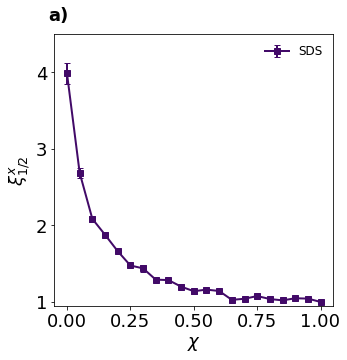

In [19]:
linestyle={'s_value':'solid'}
colors={}
labels={'s_value':'SDS'}
colors_n=plt.cm.inferno([0.2])
for i in range(len(colors_n)):
    colors[list(linestyle.keys())[i]]=colors_n[i]
fig,ax=plt.subplots(1,1,figsize=(5,5))
results_ratio['ratio_std']=results_ratio['ratio_std'].astype(float)
results_ratio['ratio_mean']=results_ratio['ratio_mean'].astype(float)
ax.errorbar(results_ratio['size'],results_ratio['ratio_mean'],yerr=results_ratio['ratio_std'].astype(float)/np.sqrt(30),lw=2,color=colors[option],label=labels[option],marker='s',capsize=3,elinewidth=2)
ax.tick_params(which='major',axis='both',labelsize=18) 
ax.set_xlabel(r'$\chi$',fontsize=18)
ax.set_ylabel(r'$\xi_{1/2}^{x}$',fontsize=18)
#ax.set_title(network.replace('_','/'),fontsize=14)
ax.legend(frameon=False,fontsize=12)

ax.set_ylim(0.95,4.5)
ax.text(0.05,1.10, 'a)', transform=ax.transAxes,
fontsize=18, fontweight='bold', va='top', ha='right')
